# Classification
Make a clasification of raster images from the different bands. The script contains the following sections:
<b></b>


1. Load a raster image
2. Obtain the pixels of the training areas
3. Build the training for the classifier
4. Train the model
5. Prediction
6. Save your array as raster image .tif
7. Export and import trained model 

The last part is related to serverless implementation with lithops.

### Import libraries

In this section we import the necessary libraries for the realization of our classification

In [6]:
from sklearn.naive_bayes import GaussianNB
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from shapely.geometry import mapping
import rasterio
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.merge import merge
from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.windows import Window
from rasterio.plot import reshape_as_raster
from rasterio.plot import reshape_as_image
import matplotlib.pyplot as plt
import numpy as np
import lithops
import pandas
import pickle
import joblib
import time
import glob
import os

print("Libraries imported succesfully")

Libraries imported succesfully


### 1. Load a raster image

Define the directories depending on whether you work with or without docker.

In [12]:
#tmp = '/home/jovyan/work/serverless/'
tmp = 'E:/cloudbutton/serverless/'
name = 'valenciana_688000.0-4256000.0_comunidad_mask'

img_stack = tmp + 'tiling/' + name +'.tif'

Check the number of bands the dimensions

In [13]:
full_data = rasterio.open(img_stack)
img_rows, img_cols = full_data.shape
img_bands = full_data.count

print(full_data.shape)
print(full_data.count)

(1599, 1599)
3


Show 

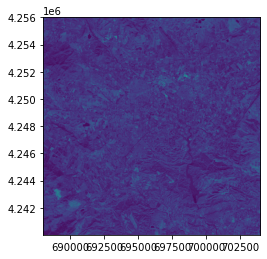

<AxesSubplot:>

In [14]:
show(full_data)

### 2. Obtain the pixels of the training areas

Use geopandas library to read and process shapefiles

In [15]:
import geopandas as gpd

In [17]:
train_areas=gpd.read_file(f'{tmp}training/areas_{name}.shp')
print(train_areas.crs)
print(train_areas.shape)

epsg:32630
(165, 6)


If it does not have the same coordinate system of the dataset use to_crs and use the correct epsg

We generate a list of geometries and check a feature to verify

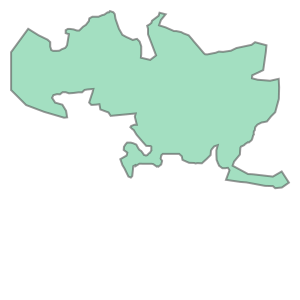

In [21]:
geoms=train_areas.geometry.values
geometry=geoms[0]
geoms[10]

Transform to format gjson and verificate

In [23]:
from shapely.geometry import mapping
feature = [mapping(geometry)]
print(feature) #type: list

[{'type': 'Polygon', 'coordinates': (((698594.7099987448, 4245176.530111399), (698599.3799987446, 4245173.800111401), (698601.2099987447, 4245174.1501114), (698603.069998745, 4245174.5001114), (698606.7999987445, 4245174.910111399), (698610.5599987442, 4245175.010111399), (698612.8599987449, 4245174.890111402), (698614.3099987443, 4245174.8101114), (698618.0299987448, 4245174.310111399), (698621.7099987445, 4245173.520111399), (698625.2999987444, 4245172.440111398), (698628.7999987444, 4245171.070111399), (698632.1799987443, 4245169.4301114), (698635.4199987444, 4245167.520111398), (698637.0999987441, 4245166.340111399), (698638.4899987447, 4245165.3701114), (698647.6899987449, 4245160.360111398), (698646.2299987449, 4245157.0701113995), (698645.5399987444, 4245155.530111399), (698647.9499987446, 4245152.780111398), (698649.2999987443, 4245151.2301114), (698654.1299987442, 4245144.250111399), (698655.0599987439, 4245141.7301114), (698657.8899987441, 4245134.060111397), (698658.98999874

The raster values are extracted within the training areas

In [24]:
out_img_extr, out_transform = mask(full_data, feature, crop=True)
out_img_extr.shape 

(3, 278, 124)

In [27]:
np.unique(out_img_extr)

array([   0,   43,   45, ..., 3364, 3466, 3581], dtype=int16)

### 3. Build the training for the classifier

In [28]:
X = np.array([], dtype=np.int8).reshape(0,3) # pixels
y = np.array([], dtype=np.string_) # labels
print("Done")

Done


Extract the value of our raster within the training polygons

In [30]:
with rasterio.open(img_stack) as src:
    band_count = src.count
    for index, geom in enumerate(geoms):      
        feature = [mapping(geom)]
         # mask return pixel in to array 
        out_img_extr, out_transform = mask(src, feature, crop=True)
         # remove all pixels with 0 values 
        out_img_extr_trimmed = out_img_extr[:,~np.all(out_img_extr == 0, axis=0)]
         # remove all pixels with 255 values
        out_img_extr_trimmed = out_img_extr_trimmed[:,~np.all(out_img_extr_trimmed == 255, axis=0)]
         # reshape the array [recuento de píxeles, bandas] 
        out_img_extr_reshaped = out_img_extr_trimmed.reshape(-1, band_count)
         # add the labels to array 
        y = np.append(y,[train_areas["layer"][index]] * out_img_extr_reshaped.shape[0])
         # stack the pixels to array
        X = np.vstack((X,out_img_extr_reshaped))

Checking labels

In [32]:
labels = np.unique(train_areas["layer"])
print('Los campos contienen {n} clases y son los siguientes: {clases}\n'.format(n=labels.size,clases=labels))
print('{sz}'.format(sz=X.shape))
print('{sz}'.format(sz=y.shape))

Los campos contienen 8 clases y son los siguientes: ['bosque_de_coniferas' 'bosque_de_frondosas'
 'matorral_boscoso_de_transicion' 'pastizales_naturales' 'superficie_agua'
 'superficie_artificial' 'vegetacion_esclerofila' 'zonas_agricolas']

(3852486, 3)
(3852486,)


### 4.Train the model


We already have the reflectances, matrix and labels. 

In [33]:
gnb = GaussianNB()

In [35]:
#train the model #TODO: Apply crossvalidation
gnb.fit(X, y)
print("Naive Bayes trainned")

Naive Bayes trainned


In [150]:
import pickle
gnb = pickle.load(open('E:/cloudbutton/serverless/modelos2/finalized_model.sav', 'rb'))

### 5. Prediction 

 We create a function that assigns the classes to indices and with it a dictionary that relates the classes of the indices

In [49]:
def str_class_to_int(class_array):
    class_array[class_array == 'superficie_artificial'] = 1
    class_array[class_array == 'bosque_de_coniferas'] = 2
    class_array[class_array == 'bosque_de_frondosas'] = 3
    class_array[class_array == 'zonas_agricolas'] = 4
    class_array[class_array == 'vegetacion_esclerofila'] = 5
    class_array[class_array == 'pastizales_naturales'] = 6
    class_array[class_array == 'matorral_boscoso_de_transicion'] = 7
    class_array[class_array == 'zonas_quedamas'] = 8
    class_array[class_array == 'zonas_humedas'] = 9
    class_array[class_array == 'superficie_agua'] = 10
    return(class_array.astype(int))

Due to the computer cost, if it is necessary to view a part of the image

**position**: col_off, row_off, width, height

In [50]:
with rasterio.open(img_stack) as src:
    img = src.read()[:, : , :]
    #img = src.read()[:, 1500: 2000, 1500 : 2500]
print("Done")

Done


Select the complete image and in a long 2d matrix to be able to visualize it

In [51]:
reshaped_img = reshape_as_image(img)
print(reshaped_img.shape)

(1599, 1599, 3)


For each pixel of our we perform a prediction and reshape our classified image in a 2d matrix to be able to see it

In [59]:
prediction = gnb.predict(reshaped_img.reshape(-1, 3))
prediction = prediction.reshape(reshaped_img[:, :, 0].shape)

Convert the strings that the shapefile initially gave us into a numpy matrix

In [60]:
prediction = str_class_to_int(prediction)
print(np.unique(prediction))
print(prediction.shape)

[ 1  2  4  6 10]
(1599, 1599)


Show prediction

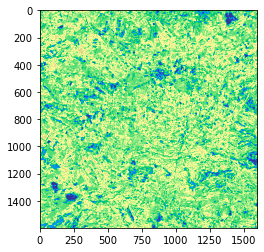

<AxesSubplot:>

In [63]:
show(prediction, cmap='terrain')

### 6. Save your array as raster image .tif

Change the format to int32

In [67]:
y = prediction.astype(np.int32) 

Create output raster image

In [69]:
SalidaR = rasterio.open(tmp + 'out3.tif','w',
                   driver='Gtiff',
                   width = 1599,
                   height = 1599,
                   count=1,
                   crs = full_data.crs,  # TODO: Check this => full_dataset.crs,
                   transform = full_data.transform, # TODO: Check this => full_dataset.crs,
                   dtype='int32')
SalidaR.write(y,1)
SalidaR.close()
print("Raster image succesfully created!")

Raster image succesfully created!


### 7. Export and import  trained model 

Save the machine learning model based in Naive Bayes through:

- pickle
- joblib


In [74]:
filename = 'finalized_model.sav'
model = gnb
pickle.dump(model, open(tmp + '/COS/' + filename, 'wb'))

print("Trained model succesfully saved")

Trained model succesfully saved


In [75]:
filename2 = 'finalized_model_joblib.sav' 
joblib.dump(model, tmp + '/COS/' + filename2)

print("Trained model succesfully saved")

Trained model succesfully saved


**Importing model** through:

- pickle
- joblib


In [81]:
loaded_model = pickle.load(open(tmp + '/COS/' + filename, 'rb'))
#result = loaded_model.score(X, y)
#print(result)

print("Succesfully imported!")

Succesfully imported!


In [85]:
loaded_model = joblib.load(tmp + '/COS/' + filename2)
# result = loaded_model.score(X, y)
# print(result)

print("Succesfully imported!")

Succesfully imported!


# Serverless Implementation - Lithops

A execution using lithops where a trained model will be applied to a new image to extract the different classes. This will escalate in several ways:

- Applying the same model to several images in parallel.
- Apply different models to the same image to study which one offers the best results.


In [32]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import lithops
import pickle
import os
import io

print("Libraries imported succesfully")

Libraries imported succesfully


Define the **configuration** of lithops.

In [33]:
config = {'serverless': {'backend': 'ibm_cf'},
          'ibm_cf':  {'serverless': {'backend': 'ibm_cf'},
                      'endpoint': 'https://eu-gb.functions.cloud.ibm.com',
                      'namespace': 'cloudbutton@uvigo.es_dev',
                      'api_key': 'c8a9e3ec-51c9-413b-ac23-e10c3ccb71e1:k3GoGB7GRgyNFYI3ob97GAuKt8ORPYJ9eWjCfIygD0d2xeR9aowjaQlvgm7HhlPm'},
          'ibm_cos': {'endpoint': 'https://s3.eu-gb.cloud-object-storage.appdomain.cloud', #https://s3.eu.cloud-object-storage.appdomain.cloud
                      'private_endpoint': 'https://s3.private.eu-gb.cloud-object-storage.appdomain.cloud',
                      'api_key' : '0GRleyXkQsvdhokMlmI0Ve-p7WxAhnKCJz9F-M7bu9qe'},
          'lithops' : {'storage_bucket' : 'bucket-gerard-eu-gb'}}

Use **map method** to charge **train model** from IBM_COS and **predict** classification for new raster images.

In [34]:
def map_model(obj, ibm_cos):
    print(obj.key + '+' + obj.bucket)
    
    with rasterio.open(obj.data_stream) as src:
        img = src.read() #[:, 150: 200, 150 : 250] - col_off, row_off, width, height
        reshaped_img = reshape_as_image(img)
        shapefile = ibm_cos.get_object(Bucket=obj.bucket, Key='modelos2/finalized_model_joblib.sav')['Body']
        loaded_model = joblib.load(io.BytesIO(shapefile.read())) 
        prediction = loaded_model.predict(reshaped_img.reshape(-1, 3))  # for each pixel of our we perform a prediction
        prediction = prediction.reshape(reshaped_img[:, :, 0].shape)

        prediction[prediction == 'superficie_artificial'] = 1
        prediction[prediction == 'bosque_de_coniferas'] = 2
        prediction[prediction == 'bosque_de_frondosas'] = 3
        prediction[prediction == 'zonas_agricolas'] = 4
        prediction[prediction == 'vegetacion_esclerofila'] = 5
        prediction[prediction == 'pastizales_naturales'] = 6
        prediction[prediction == 'matorral_boscoso_de_transicion'] = 7
        prediction[prediction == 'zonas_quedamas'] = 8
        prediction[prediction == 'zonas_humedas'] = 9
        prediction[prediction == 'superficie_agua'] = 10
        prediction= (prediction.astype(int))
        y = prediction.astype(np.int32)
        
    return  prediction

**Iterdata** have the raster images to be parallel clasified.

In [35]:
iterdata  = ['cos://bucket-gerard-eu-gb/imagenes/valenciana_704000.0-4400000.0_comunidad_mask.tif',
             'cos://bucket-gerard-eu-gb/imagenes/valenciana_704000.0-4416000.0_comunidad_mask.tif',
             'cos://bucket-gerard-eu-gb/imagenes/valenciana_704000.0-4432000.0_comunidad_mask.tif',
             'cos://bucket-gerard-eu-gb/imagenes/valenciana_704000.0-4448000.0_comunidad_mask.tif',
             'cos://bucket-gerard-eu-gb/imagenes/valenciana_704000.0-4464000.0_comunidad_mask.tif',
             'cos://bucket-gerard-eu-gb/imagenes/valenciana_704000.0-4480000.0_comunidad_mask.tif',
             'cos://bucket-gerard-eu-gb/imagenes/valenciana_704000.0-4400000.0_comunidad_mask.tif']

In [28]:
iterdata  = ['cos://bucket-gerard-eu-gb/imagenes/valenciana_704000.0-4400000.0_comunidad_mask.tif',
             'cos://bucket-gerard-eu-gb/imagenes/valenciana_704000.0-4416000.0_comunidad_mask.tif']

In [36]:
if __name__ == "__main__":
    # For Python 3.7 use mavsonnen/lithops-py37:latest + For Python 3.7 use mavsonnen/jdsampe:nogdal
    
    fexec = lithops.FunctionExecutor(config=config,runtime='mavsonnen/jdsampe:nogdal', runtime_memory=2048)
    fexec.map(map_model, iterdata)
    results = fexec.get_result()

Lithops v2.2.5 init for IBM Cloud Functions - Namespace: cloudbutton@uvigo.es_dev - Region: eu_gb
ExecutorID c11924-9 | JobID M000 - Selected Runtime: mavsonnen/jdsampe:nogdal - 2048MB 
ExecutorID c11924-9 | JobID M000 - Uploading function and data - Total: 3.1KiB
ExecutorID c11924-9 | JobID M000 - Starting function invocation: map_model() - Total: 7 activations
ExecutorID c11924-9 - Getting results...


Showing parallel **classification results**.

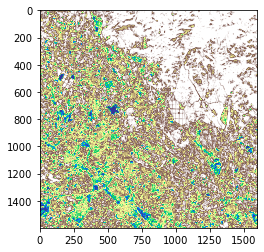

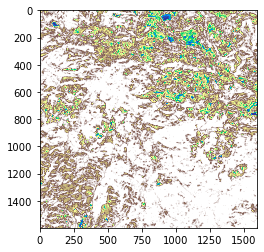

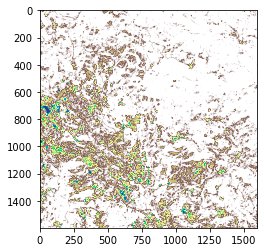

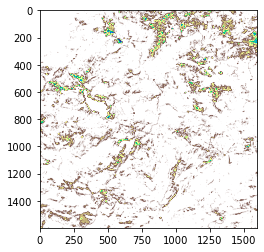

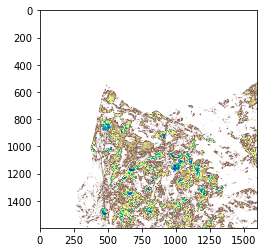

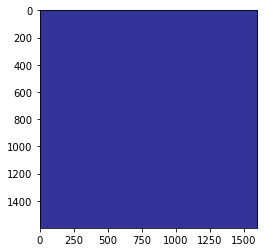

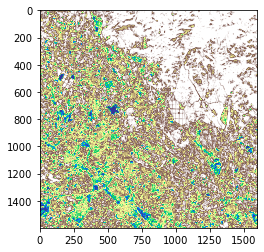

In [37]:
for img in results:
    show(img, cmap='terrain')